## CoMD
Classical molecular dynamics proxy application.  
  
  ---
clang++-5.0.1 -g -O3 -march=native    
  
(**Haswell**) Intel(R) Xeon(R) CPU E5-2699 v3 @ 2.30GHz  
-- 18 cpu cores, 72 threads.  
-- **2 Floating Point Mul Ports**. 

`divsd`: 10-20 Cycles  
`mulsd`: 5 Cycles  
`movsd`: 3 Cycles  
L1 Cache: 32 kB, 8 way, 64 sets, 64 B line size, **latency 4**, per core.    
L2 Cache: 256 kB, 8 way, 512 sets, 64 B line size, **latency 12**, per core.  
Data from Agner

| Empirical Roofline Toolkit | L1 Cache | L2 Cache | L3 Cache | DRAM |
|:---|:------:|:--------:|:----------:|:-----|
|Cache Lines / Cycle | .9715 | .3050 | 0.2188 | 0.1067 |

---
### `ljForce.c`
#### Slight Changes in openMP source code not shown (except #pragma)
```c
|144|int ljForce(SimFlat* s)
       (...)
       #pragma omp parallel for reduction(+:ePot)
|169|  for (int iBox=0; iBox<s->boxes->nLocalBoxes; iBox++)
         (...)
|175|    for (int jTmp=0; jTmp<nNbrBoxes; jTmp++)
           (...)
|185|      for (int iOff=iBox*MAXATOMS,ii=0; ii<nIBox; ii++,iOff++)
             (...)
```           
|`for ( ) : Line 189`|  CPUTIME  | Inst per Cycle | L1 DC Miss % |  L1 Loads/Cycle |
|:---|:---:|:---:|:---:|:---:|:---:|:---:|
| **Serial Run** | 76.7%  |   1.01    | 0.6%  | 0.40|
|**72 Thread Run** | 53.6%  |    2.12    | 0.4% | 1.02 |
```c      
|189|        for (int jOff=MAXATOMS*jBox,ij=0; ij<nJBox; ij++,jOff++)
|190|        {                                                        
|191|          real_t dr[3];
|192|          int jId = s->atoms->gid[jOff];  
|193|          if (jBox < s->boxes->nLocalBoxes && jId <= iId )      //  5.9% CPUTIME
|194|            continue; // don't double count local-local pairs.
|195|          real_t r2 = 0.0;
|196|          for (int m=0; m<3; m++)
|197|          {
|198|            dr[m] = s->atoms->r[iOff][m]-s->atoms->r[jOff][m];  //  6.4% CPUTIME
```
  
|`Line 199`|  CPUTIME  | Inst per Cycle | L1 DC Miss % | L1 Loads/Cycle | 
|:---|:---:|:---:|:---:|:---:|:---:|:---:|
| **Serial Run** | 11.7%  |    1.38     | 1.6% |0.48 |
|**72 Thread Run** | 9.4%  |    2.40     | 0.6% |1.09 |
```c
|199|            r2+=dr[m]*dr[m];                                     
|200|          }
|201|
|202|          if ( r2 > rCut2) continue;                            //  6.8% CPUTIME
|203|  
|204|          // Important note:
|205|          // from this point on r actually refers to 1.0/r
|206|          r2 = 1.0/r2;
```
|`Line 207`|  CPUTIME  | Inst per Cycle | L1 DC Miss % | L1 Loads/Cycle | 
|:---|:---:|:---:|:---:|:---:|:---:|:---:|
| **Serial Run** | 12.8%  |    0.68     | 0.2% |0.39 |
|**72 Thread Run** | 9.4%  |    1.44    | 0.2% |0.85|
                      /*         NOTE: Dependency Chain            */
```c        
|207|          real_t r6 = s6 * (r2*r2*r2);                           
|208|          real_t eLocal = r6 * (r6 - 1.0) - eShift;             //  5.4% CPUTIME
|209|          s->atoms->U[iOff] += 0.5*eLocal;                      //  6.6% CPUTIME
|210|          s->atoms->U[jOff] += 0.5*eLocal;
|211|
|212|          // calculate energy contribution based on whether
|213|          // the neighbor box is local or remote
|214|          if (jBox < s->boxes->nLocalBoxes)
|215|            ePot += eLocal;
|216|          else
|217|            ePot += 0.5 * eLocal;
|218|
|219|          // different formulation to avoid sqrt computation
|220|          real_t fr = - 4.0*epsilon*r6*r2*(12.0*r6 - 6.0);
|221|          for (int m=0; m<3; m++)
|222|          {
|223|            s->atoms->f[iOff][m] -= dr[m]*fr;
|224|            s->atoms->f[jOff][m] += dr[m]*fr;                         
|225|          }
|226|        }// loop over atoms in jBox 
|227|      } // loop over atoms in iBox
|228|    } // loop over neighbor boxes
|229|  } // loop over local boxes in system
       (...)
|236|}       
```

### Core Bound - FP Operations - Dependency

---
### Scaling 

In [3]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

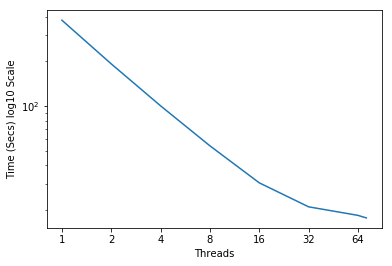

In [7]:

fig,ax = plt.subplots()
ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=10)
ax.set_xlabel('Threads')
ax.set_ylabel('Time (Secs) log10 Scale')
ax.set_xticks([1,2,4,8,16,32,64])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
# ax.set_yticks([10, 100])
# ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax.plot([1,2,4,8,16,32,64,72], [378.010, 192.365, 100.516,54.137,30.542,21.070,18.460,17.745])
plt.show()